In [87]:
!pip install opencv-python

In [67]:
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import glob
import copy
import os
import errno
from PIL import Image
from tensorflow.python.client import device_lib
from tensorflow.compat.v1.keras.preprocessing import image
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.__version__

'1.15.5'

In [3]:
def test_gpu():
    tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True))
    print(tf.add([1.0, 2.0], [3.0, 4.0])) # Create two tensors for gpu test.

In [4]:
test_gpu()

Executing op Add in device /job:localhost/replica:0/task:0/device:DML:0
tf.Tensor([4. 6.], shape=(2,), dtype=float32)


In [5]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [6]:
print(get_available_devices()) # Return a list of devices we can use in the notebook.

['/device:CPU:0', '/device:DML:0', '/device:DML:1']


In [7]:
rands = []

for iter_ in range(1, 11):
    rand = random.randint(1, 50)
    rands.append(rand)

In [8]:
print(rands)

[26, 18, 10, 31, 12, 28, 31, 26, 34, 1]


In [11]:
def image_view(dir_, rands):
    img = 1
    for image in dir_:
        plt.subplot(4, 4, img)
        plt.imshow(
            mpimg.imread('{dir_}/{rands}.png'.format(dir_=dir_, rands=rands[img]))
        )
        plt.axis('off')
        plt.show()
        print(
            'Image shape:', (mpimg.imread('{dir_}/{rands}.png'.format(dir_=dir_, rands=rands[img])).shape),
            'Color Depth:', (mpimg.imread('{dir_}/{rands}.png'.format(dir_=dir_, rands=rands[img])).max())
        )
        img = img + 1

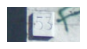

Image shape: (78, 161, 3) Color Depth: 1.0


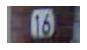

Image shape: (37, 74, 3) Color Depth: 0.80784315


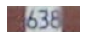

Image shape: (21, 60, 3) Color Depth: 0.9490196


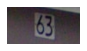

Image shape: (87, 171, 3) Color Depth: 0.5921569


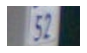

Image shape: (47, 87, 3) Color Depth: 0.84705883


In [12]:
image_view('train', rands)

In [13]:
def append_images(dir_):
    imgs = []
    for image in glob.glob(dir_ + '/*.png'):
        img = copy.deepcopy(Image.open(image))
        imgs.append(img)
    
    print('Total appended images:', len(imgs))
    
    return imgs

In [14]:
imgs = append_images('train')

Total appended images: 33402


In [95]:
def image_to_gray(path, d_path):
    imgs_grayscale = []
    one_channel_count = 0
    images = [i for i in os.listdir(path) if os.path.isfile(os.path.join(path, i))]
    print('Joined in:', path)
    for image in images:
        try:
            img = cv2.imread(image).copy()
            img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(os.path.join(d_path, image), img_g)
        except:
            one_channel_count = one_channel_count + 1
            
    print('Not convterted, images with one channel color:', one_channel_count)
    
    return imgs_grayscale

In [96]:
path = r'train/'
d_path = 'train_gray/'

try:
    os.makedirs(d_path)
except:
    print('Warning: train_gray directory already exist')
        
imgs_g = image_to_gray(path, d_path)

Joined in: train/
Not convterted, images with one channel color: 33404


In [127]:
def image_resize(path, d_path, dim):
    imgs_resized = []
    resized = 0
    images = list(filter(lambda i: os.path.isfile(os.path.join(path, i)), os.listdir(path)))
    print('Joined in:', path)
    for image in glob.glob(path + '*.png'):
        img = cv2.imread(image)
        img_r = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        cv2.imwrite(os.path.join(d_path, image), img_r)
            
    print('Not convterted, images with one channel color:', resized)
    
    return imgs_resized

In [129]:
path = 'train/'
d_path = 'train_resized/'
dim=(32, 32)

try:
    os.makedirs(d_path)
except:
    print('Warning: train_resized directory already exist')
    
imgs_resized = image_resize(path, d_path, dim)

Joined in: train/
Not convterted, images with one channel color: 0


In [130]:
def datagens():
    train_datagen = ImageDataGenerator(
        rescale=1./255, # Appling feature scaling.
        shear_range=0.2, # Shear transformation.
        zoom_range=0.2, # Zoom transformation.
        horizontal_flip=True # Flipping image transformation. 
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255) # Appling feature scaling.
    
    return train_datagen, test_datagen

In [131]:
train_datagen, test_datagen = datagens()

In [132]:
train_path = 'train/'
test_path = 'test/'

In [133]:
def datagenerator(train_path, test_path):
    train_generator = train_datagen.flow_from_directory(
        train_path, # Get training directory.
        target_size=(32, 32), # Resize target_size to train by 32x32.
        batch_size=16, # Set 16 training samples.
        class_mode='binary'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_path, # Get testing directory.
        target_size=(32, 32), # Resize target_size to test by 32x32.
        batch_size=16, # Set 16 training samples.
        class_mode='binary'
    
    return train_generator, test_generator

In [134]:
train_generator, test_generator = datagenerator(train_path, test_path)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [ ]:
def model():
    model = tf.keras.models.Sequential()
    
    model.add(
        tf.keras.layers.Conv2D(
        filters=16, # Number of ouput filters in the convolution.
        kernel_size=3, # Height and Width of the 2D convolution window.
        activation='relu', # Activation function, set as relu.
        input_shape=(32, 32, 3) # Desired input shape, matching target_size.
        )
    )

    model.add(
        tf.keras.layers.MaxPool2D(
        pool_size=2, # Pooling window size. In this case (2, 2).
        strides=2 # Move distance for each pool step.
        )
    )

    model.add(
        tf.keras.layers.Conv2D(
        filters=16, # Number of ouput filters in the convolution.
        kernel_size=3, # Height and Width of the 2D convolution window.
        activation='relu' # Activation function, set as relu.
        )
    )

    model.add(
        tf.keras.layers.MaxPooling2D(
        pool_size=2, # Pooling window size. In this case (2, 2).
        strides=2 # Move distance for each pool step.
        )
    )
    
    model.add(
        tf.keras.layers.Flatten()
    )
    
    model.add(
        tf.keras.layers.Dense(
            units=64,
            activation='relu'
        )
    )
    
    model.add(
        tf.keras.layers.Dense(
            units=1,
            activation='relu'
        )
    )
    
    model.compile(
        optimizer=Adam(0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = model()

In [ ]:
model.summary()